In [5]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from math import inf

In [6]:
print(f' TensorFlow version: {tf.__version__}')
print(f' NumPy versio: {np.__version__}')

 TensorFlow version: 2.10.0
 NumPy versio: 1.23.4


## Algorithms implementation

### Utils

In [177]:
def dbscan(x):
    x_list = x.tolist()
    clustering = DBSCAN(eps=2).fit(x.reshape(-1, 1))
    x_labels = clustering.labels_.tolist()
    clusters = [[] for _ in range(max(x_labels)+1)]
    noice = []
    for i in range(len(x_list)):
        if x_labels[i] == -1:
            noice.append(x_list[i])
        else:
            clusters[x_labels[i]].append(x_list[i])
    return clusters, noice

### Stage 1 - Flow clustering

In [265]:
def subset_of_sets(_set: set, sets):
    return len([_ for s in sets if all([x in s for x in _set])]) > 0


def tp_cluster(clusters: set, noise: set, tp_ratio: float, tp_deviation: float):
    """
        Parameters
        clusters : set
            Set of DBSCAN cluster sets in descending throughput order
        noise : set
            Set of DBSCAN noice flows
        tp_ratio : float
            Ratio used to determine if two DBSCAN clusters can be combined into one TPCluster
        tp_deviation : float
            The relative distance a noise flow can be away from a TPCluster to be assigned to that cluster

        Returns
        cs : set
            set of TPClusters
    """

    r = 0
    cs = []
    for cluster in clusters:
        if not subset_of_sets(cluster, cs):
            cs.append(cluster)
            m = max(cluster)
            for cluster_k in clusters:
                if cluster_k is cluster: continue
                m_prim = max(cluster_k)
                if (1 - tp_ratio) * m < m_prim < m:
                    cs[r] += cluster_k
            r += 1
    for n_j in noise:
        delta_min = inf
        a = None
        for i in range(len(cs)):
            m = max(cs[i])
            if (-tp_deviation * m) <= (m - n_j) <= delta_min:
                delta_min = m - n_j
                a = i
        if a:
            cs[a].append(n_j)
        else:
            cs[0].append(n_j)
    return cs


### Stage 2 - FOF computation

In [274]:
def compute_fof(cs):
    """
        Parameters
        clusters : list of TPClusters

        Returns:
            FOF score for each flow in each cluster
    """
    f = [[_ for _ in c_i] for c_i in cs]
    k = len(cs)
    for i in range(k):
        c_np = np.array(cs[i])
        s_labels = KMeans(n_clusters=k).fit(c_np.reshape((-1, 1))).labels_
        s_count = max(s_labels) + 1
        c_prim = 0
        for s_i in range(s_count):
            c_prim = max(c_prim, np.sum(c_np * (s_labels == s_i)) / np.sum(s_labels == s_i))
        for j in range(len(cs[i])):
            f[i][j] = np.abs(cs[i][j] - c_prim) / np.abs(c_prim)
    return f


## Testing

In [276]:
# dbscan test
X1 = np.random.normal(10, 1, 10)
X2 = np.random.normal(20, 1, 10)
X3 = np.random.normal(30, 1, 10)
X = np.concatenate((X1, X2, X3, np.array([0])), axis=0)
print(dbscan(X))

([[8.75477003000384, 10.1257398484037, 9.210688519653356, 9.50659805430878, 9.676483766922217, 8.618932970266242, 9.164731952778231, 11.863227953857136, 9.907727004957595, 10.00197963257761], [19.296828019687563, 19.53045571919184, 22.388702590416493, 21.56387295935107, 21.260355184058238, 19.38420758205138, 19.43669647326851, 18.737671554791604, 19.581234297796264, 19.583534972596382], [29.66309837900521, 29.694191452735787, 29.035611470902833, 31.13354909122758, 29.165875496423403, 30.812353630840875, 29.823536556829787, 29.456903479270405, 30.470706936734473, 28.312863403994804]], [0.0])


In [277]:
# k_means test
Y = np.random.normal(10, 1, 10)
k_means = KMeans(n_clusters=4).fit(X.reshape(-1, 1)).labels_
print(Y)
print(k_means)
print(np.sum(X * (k_means == 0)) / np.sum(k_means == 0))

[10.23808206 10.77027584 10.63152416  9.46616636 10.60282474 10.99136685
  9.31654056  9.63992683  9.90298727  9.86775042]
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 3]
29.756868989796523


In [278]:
# Stage 1 test
print("X:", X)
clusters, noise = dbscan(X)
print("Clusters and noise:", clusters, noise)
tpc = tp_cluster(clusters, noise, 0.2, 0.2)

X: [ 8.75477003 10.12573985  9.21068852  9.50659805  9.67648377  8.61893297
  9.16473195 11.86322795  9.907727   10.00197963 19.29682802 19.53045572
 22.38870259 21.56387296 21.26035518 19.38420758 19.43669647 18.73767155
 19.5812343  19.58353497 29.66309838 29.69419145 29.03561147 31.13354909
 29.1658755  30.81235363 29.82353656 29.45690348 30.47070694 28.3128634
  0.        ]
Clusters and noise: [[8.75477003000384, 10.1257398484037, 9.210688519653356, 9.50659805430878, 9.676483766922217, 8.618932970266242, 9.164731952778231, 11.863227953857136, 9.907727004957595, 10.00197963257761], [19.296828019687563, 19.53045571919184, 22.388702590416493, 21.56387295935107, 21.260355184058238, 19.38420758205138, 19.43669647326851, 18.737671554791604, 19.581234297796264, 19.583534972596382], [29.66309837900521, 29.694191452735787, 29.035611470902833, 31.13354909122758, 29.165875496423403, 30.812353630840875, 29.823536556829787, 29.456903479270405, 30.470706936734473, 28.312863403994804]] [0.0]


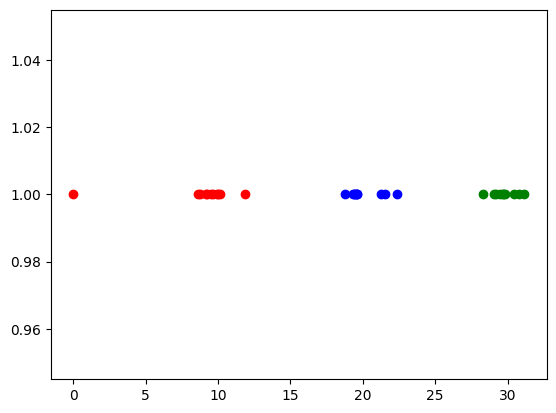

In [281]:
plt.scatter(np.array(tpc[0]), np.ones((1, len(tpc[0]))), color ='red')
plt.scatter(np.array(tpc[1]), np.ones((1, len(tpc[1]))), color = 'blue')
plt.scatter(np.array(tpc[2]), np.ones((1, len(tpc[2]))), color = 'green')

In [290]:
# Stage 2 test
print(compute_fof(tpc))

[[0.26202463072815113, 0.14645997802718771, 0.22359339671470693, 0.1986499718891548, 0.18432961040961318, 0.2734748920116691, 0.22746726368024753, 0.0, 0.16483717218497362, 0.15689223274803304, 1.0], [0.13809976519373704, 0.12766469426630062, 0.0, 0.036841332262749896, 0.050398070267870076, 0.1341969234810055, 0.1318524869954543, 0.16307470345279038, 0.1253966495504732, 0.12529388902690886], [0.03708548208423529, 0.03607614813943777, 0.05745477209884491, 0.010647843699447745, 0.05322618074492601, 0.00022129391886586896, 0.0318773865346288, 0.04377891848585393, 0.01086913761831373, 0.08091640100656101]]
